In [99]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
import pickle

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, RandomSampler, random_split
from torchvision.utils import make_grid
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os
from PIL import Image

### Import Latent Space Embeddings

In [10]:
# load in embedding dataframe
df = pd.read_csv('../data/encoded_data.csv', index_col=0)

In [40]:
# split into training & validation sets

train_len = int(0.8 * df.shape[0])
#test_len = df.shape[0] - train_len

train_indices = np.random.choice(df.shape[0], size=train_len, replace=False)
train_dataset = df.iloc[train_indices,:]
test_dataset = df.drop(index=df.iloc[train_indices, :].index.tolist())

In [76]:
# normalize the data
scaler = preprocessing.StandardScaler().fit(train_dataset)

train_scaled = scaler.transform(train_dataset)
test_scaled = scaler.transform(test_dataset)

### Importing in Originial Images

In [60]:
# Writing a dataloader to load image data from ../data/ folder

class DASImageDataset(Dataset):
    def __init__(self, root_dir, transform=transforms.ToTensor()):
        self.root_dir = root_dir
        self.files = os.listdir(self.root_dir)
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, index):
        img_file =(os.path.join(self.root_dir, self.files[index]))
        img = Image.open(img_file)
        
        if self.transform:
            img = self.transform(img)
        
        return img, self.files[index]

In [61]:
# Applying custom convolution kernel to the image

from torch.functional import F

class DiagonalEdge(object):
    def __init__(self):
        self.weight_left = torch.tensor([[-1, -1, 2], 
                                         [-1, 2, -1],
                                         [2, -1, -1]], dtype=torch.float32)
        
        self.weight_right = torch.flip(self.weight_left, [0])

    
    def __call__(self, img):
        img = F.conv2d(img.unsqueeze(0), self.weight_left.unsqueeze(0).unsqueeze(0), padding=1)
        img += F.conv2d(img, self.weight_right.unsqueeze(0).unsqueeze(0), padding=1)
        img = torch.sigmoid(img)
        img = (img > 0.53)*1.0
        return img.squeeze(0)
    
class ScalePixels(object):
    def __call__(self, img):
        img = (img - img.min())/(img.max() - img.min())
        return img
    

In [90]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.GaussianBlur(3, sigma=0.5),
    transforms.ToTensor(),
    DiagonalEdge(),
])

images = DASImageDataset(root_dir='/home/hunteryt/notebooks/Capstone_Project/south_ch_10000to47499_fs100_bpf14to35Hz', transform=transform)

orig_transform = transforms.Compose([transforms.ToTensor()])
orig_images = DASImageDataset(root_dir='/home/hunteryt/notebooks/Capstone_Project/south_ch_10000to47499_fs100_bpf14to35Hz', transform=orig_transform)

### Generating Clusters

In [109]:
# load in best models 
four_gmm_file_name = './model/gmm_4_clusters.sav'
four_gmm_model = pickle.load(open(four_gmm_file_name, 'rb'))

five_gmm_file_name = './model/gmm_5_clusters.sav'
five_gmm_model = pickle.load(open(five_gmm_file_name, 'rb'))

In [53]:
def gmm_bic_score(estimator, X):
    """Callable to pass to GridSearchCV that will use the BIC score."""
    # Make it negative since GridSearchCV expects a score to maximize
    return -estimator.bic(X)


param_grid = {
    "n_components": range(1, 7),
    "covariance_type": ["spherical", "tied", "diag", "full"],
}
grid_search = GridSearchCV(
    GaussianMixture(), param_grid=param_grid, scoring=gmm_bic_score
)
grid_search.fit(train_scaled)

GridSearchCV(estimator=GaussianMixture(),
             param_grid={'covariance_type': ['spherical', 'tied', 'diag',
                                             'full'],
                         'n_components': range(1, 7)},
             scoring=<function gmm_bic_score at 0x7f1c504b49d0>)

In [56]:
df_results = pd.DataFrame(grid_search.cv_results_)[
    ["param_n_components", "param_covariance_type", "mean_test_score"]
]
df_results["mean_test_score"] = -df_results["mean_test_score"]
df_results = df_results.rename(
    columns={
        "param_n_components": "Number of components",
        "param_covariance_type": "Type of covariance",
        "mean_test_score": "BIC score",
    }
)
df_results.sort_values(by="BIC score").head()



,Number of components,Type of covariance,BIC score
21,4,full,-44669.579318
22,5,full,-43733.301322
20,3,full,-43702.402254
23,6,full,-42368.400609
19,2,full,-39034.323910


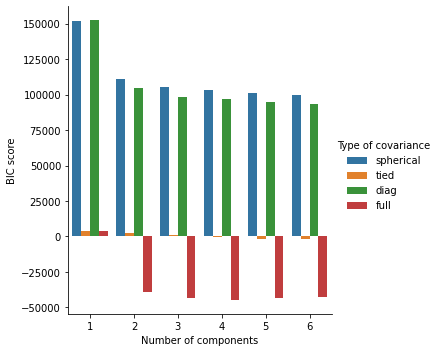

In [57]:
sns.catplot(
    data=df_results,
    kind="bar",
    x="Number of components",
    y="BIC score",
    hue="Type of covariance",
)
plt.show()

In [101]:
# trying 5 clusters
five_cluster_gmm = GaussianMixture(n_components=5)
five_cluster_gmm.fit(train_scaled)

GaussianMixture(n_components=5)

In [108]:
# save 5 cluster gmm model 
#five_file_name = './model/gmm_5_clusters.sav'
#pickle.dump(five_cluster_gmm, open(five_file_name,'wb'))

# save grid search gmm
#gs_file_name = './model/gmm_4_clusters.sav'
#pickle.dump(grid_search.best_estimator_, open(gs_file_name, 'wb'))

### Visualizing Clusters & Determining Performance

In [64]:
# get values of centroids
centroids = grid_search.best_estimator_.means_

In [77]:
# visualize samples from each cluster
Y_ = grid_search.predict(test_scaled)

# tag each sample with its predicted cluster
test_dataset['cluster_id'] = Y_

In [102]:
# get predictions for 5 cluster gmm
Y_5 = five_cluster_gmm.predict(test_scaled)
test_dataset['5_cluster_id'] = Y_5

In [89]:
images[0][0]

tensor([[[0., 1., 0.,  ..., 1., 0., 1.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 1.],
         [1., 0., 0.,  ..., 0., 1., 0.]]])

In [104]:
def view_batch(batch):
    grid = make_grid(batch, nrow=8, padding=5)
    plt.figure(figsize=(20,10))
    plt.imshow(np.transpose(grid, (1,2,0)))
    plt.show()

def visualize_samples_from_cluster(df, clust_id, n=12, clust_id_name='cluster_id'):
    df_samples = df[df[clust_id_name] == clust_id]
    num_samples = df_samples.shape[1]
    batch_pre = []
    batch_post = []
    
    for i in range(n):
        idx = np.random.choice(num_samples)
        fl_name = df_samples.index.values[idx]
        #print(fl_name)
        j, _ = [(j,f) for j,(_,f) in enumerate(images) if f.startswith(fl_name)][0]
        batch_pre.append(orig_images[j][0])
        batch_post.append(images[j][0])
    
    view_batch(batch_pre)
    view_batch(batch_post)

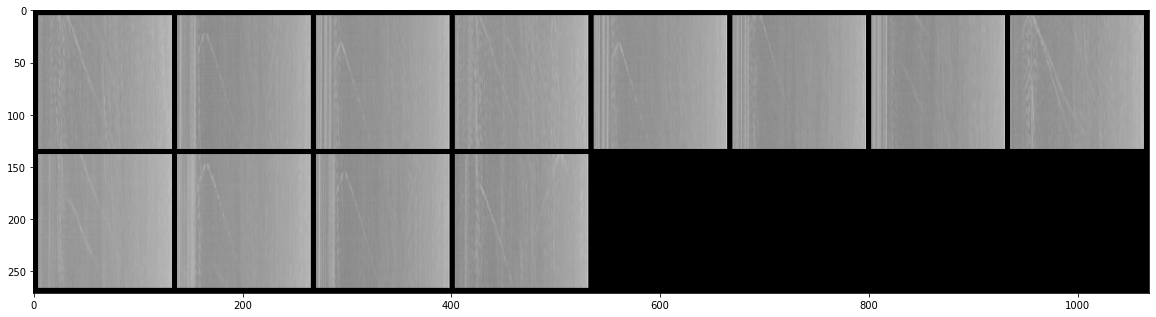

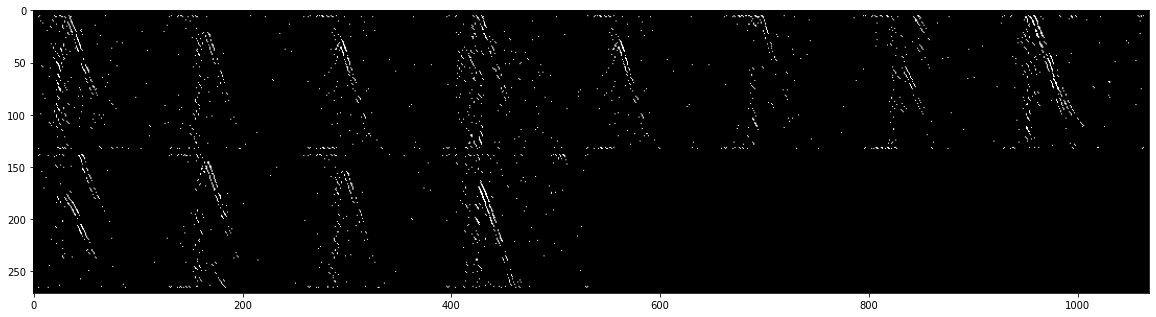

In [95]:
visualize_samples_from_cluster(test_dataset, 0)

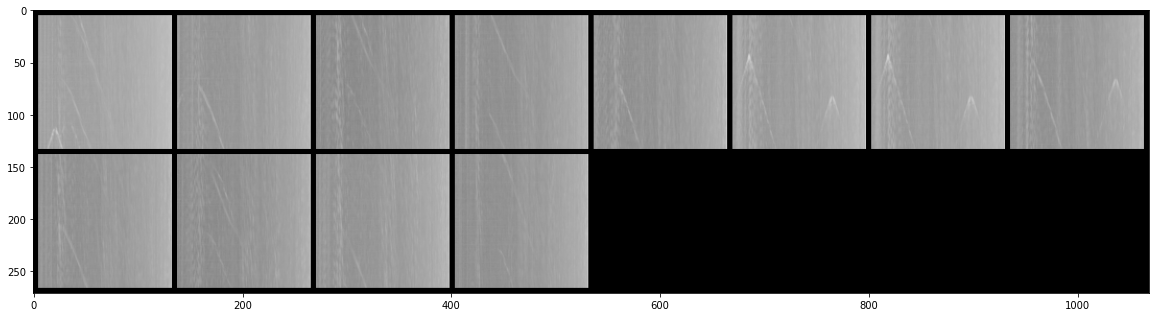

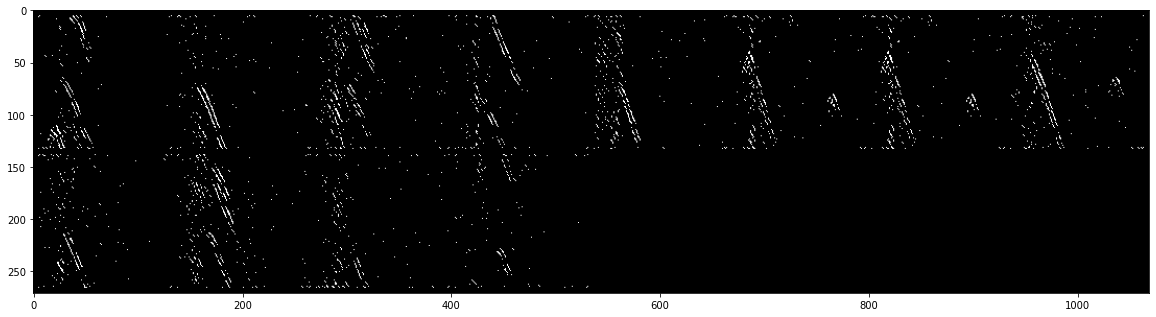

In [96]:
visualize_samples_from_cluster(test_dataset, 1)

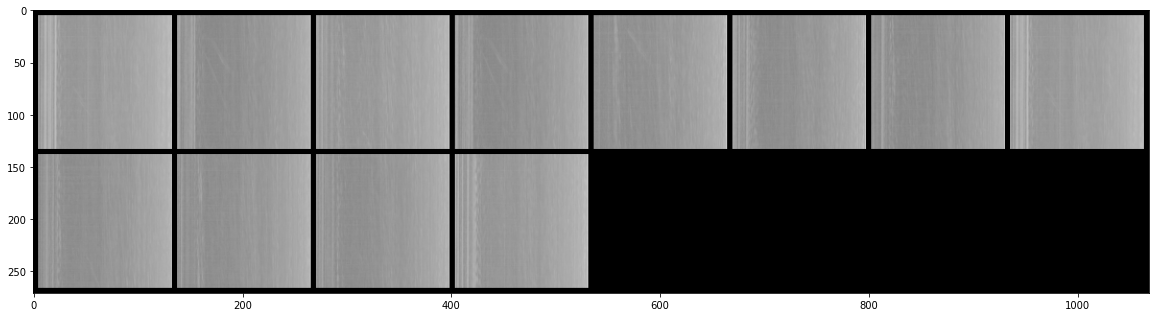

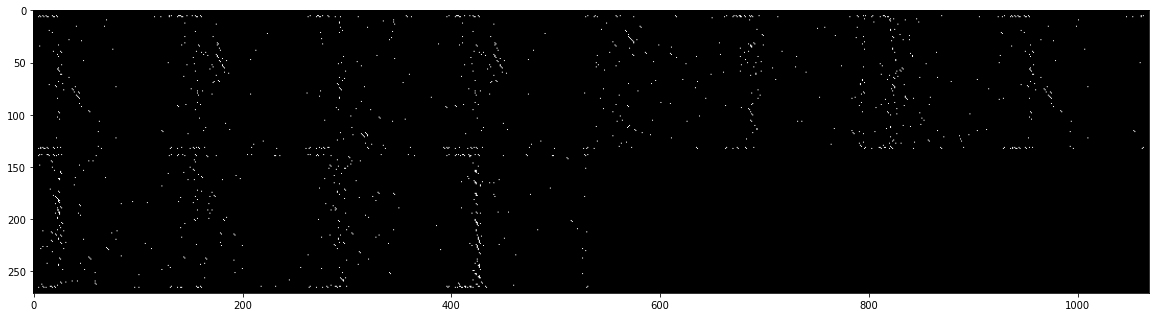

In [97]:
visualize_samples_from_cluster(test_dataset, 2)

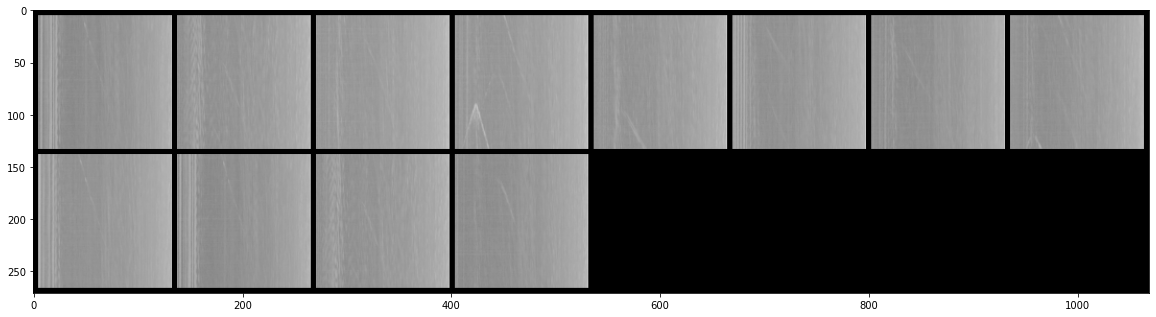

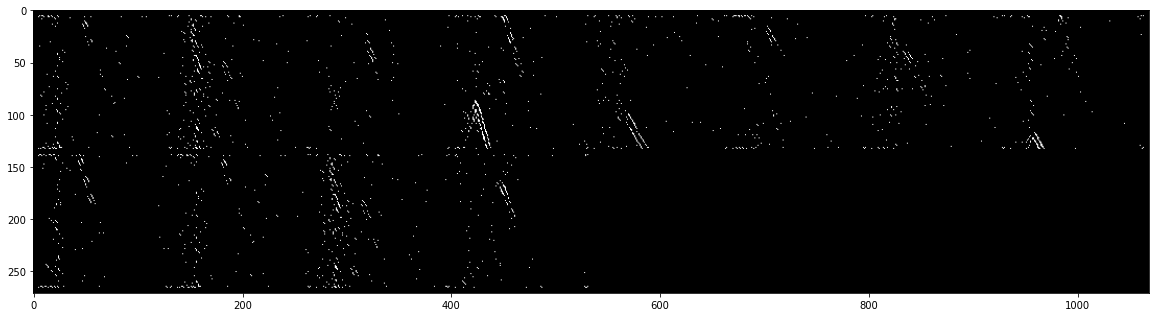

In [98]:
visualize_samples_from_cluster(test_dataset, 3)

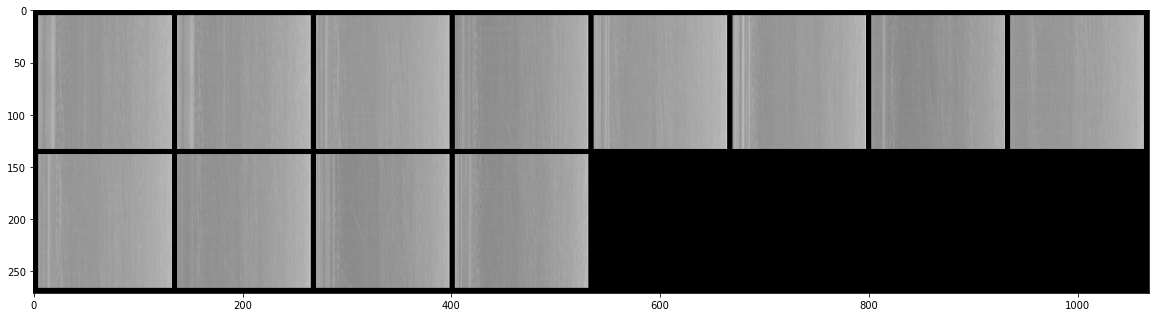

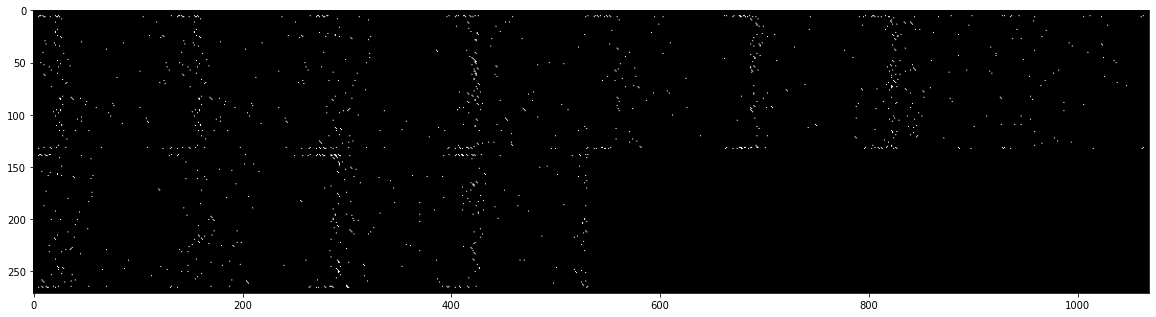

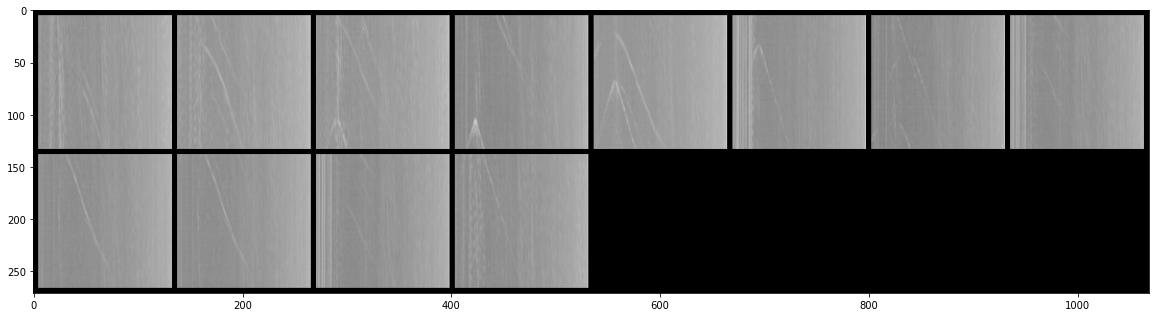

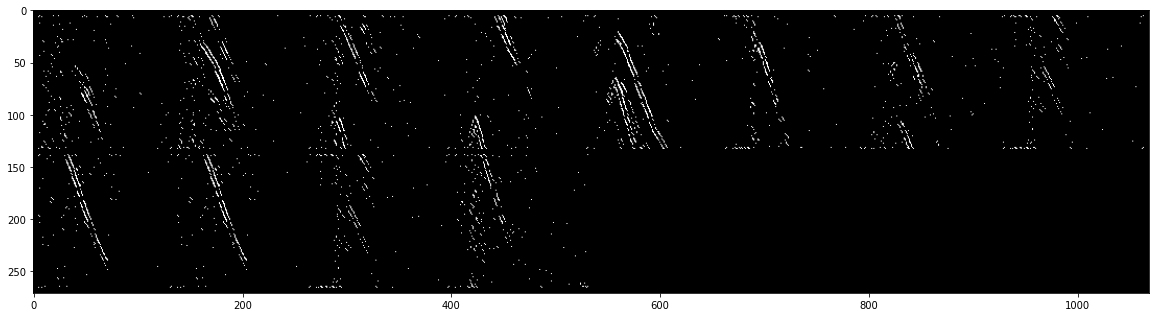

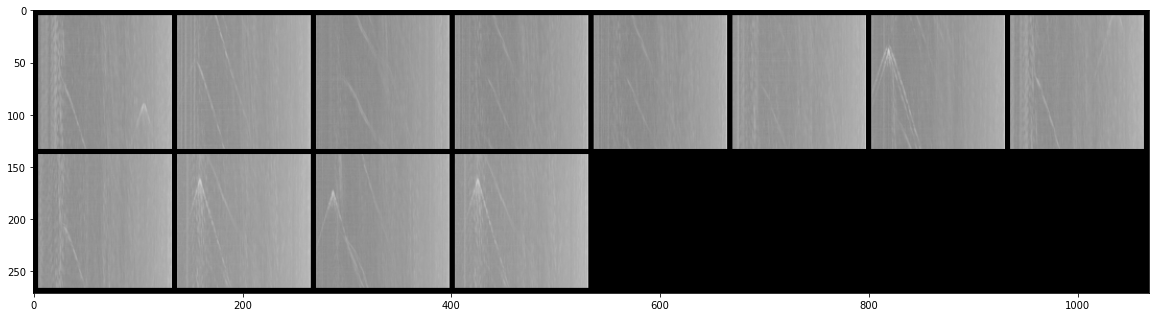

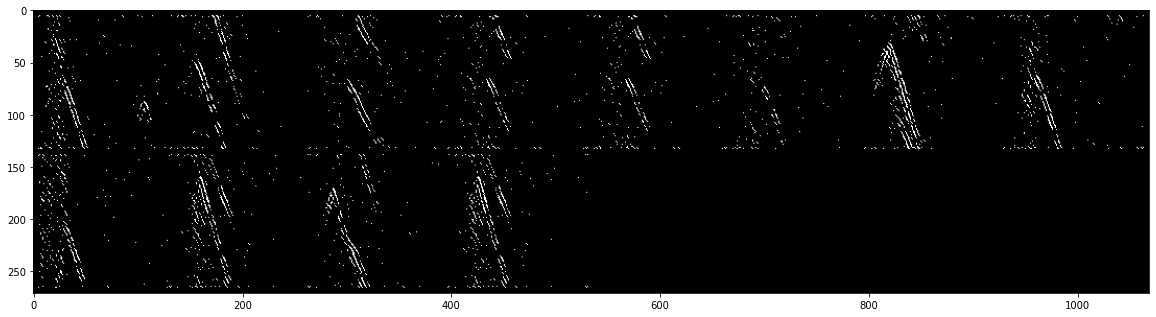

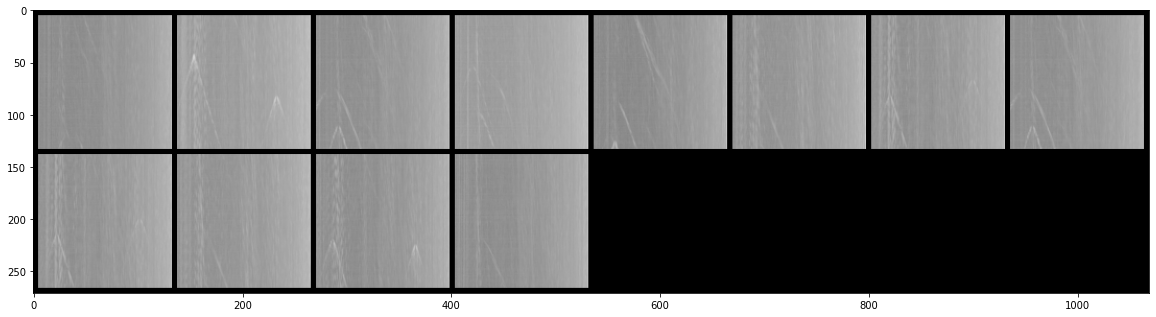

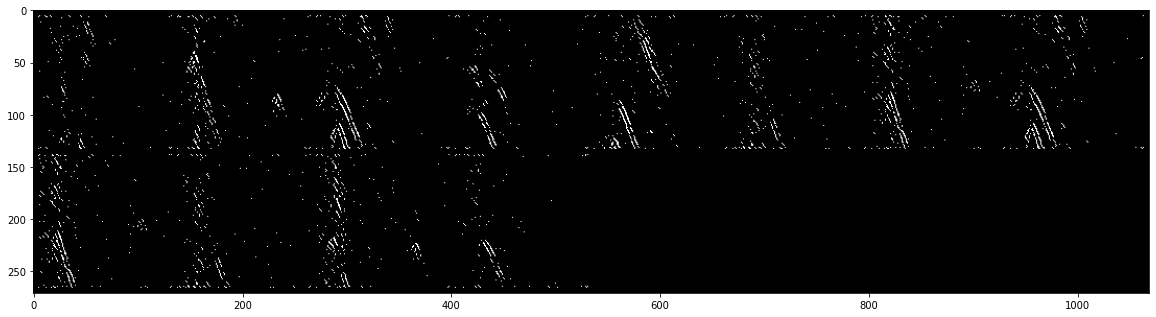

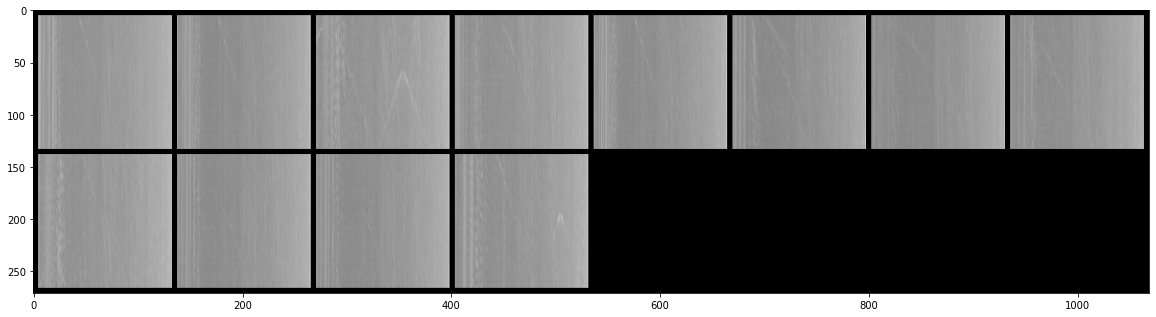

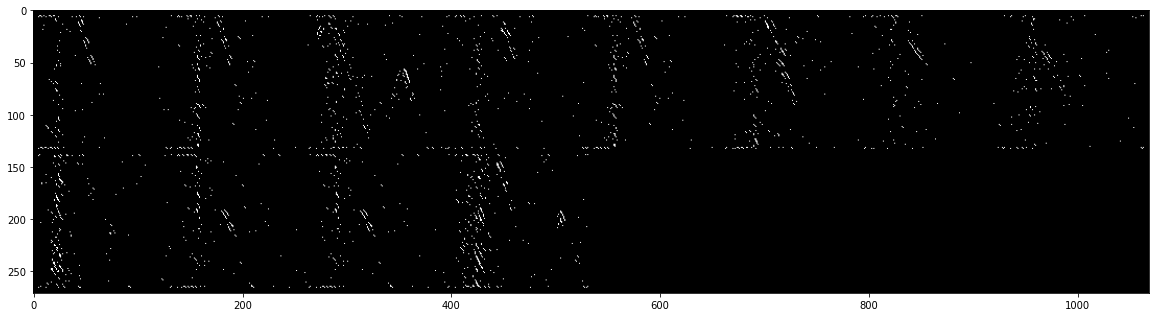

In [105]:
for i in range(5):
    visualize_samples_from_cluster(test_dataset, i, clust_id_name='5_cluster_id')